In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/weights.hdf5
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/utilities.py
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/ResUNet-MRI.json
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/resnet-50-MRI.json
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/weights_seg.hdf5
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/data_mask.csv
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/data.csv
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/TCGA_DU_701

In [2]:
df = pd.read_csv('/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/data.csv')
df.head()

,patient_id,image_path,mask_path
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...


In [3]:
df.columns

Index(['patient_id', 'image_path', 'mask_path'], dtype='object')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

sample = df.iloc[0]
base_path = '/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/'

img = cv2.imread(os.path.join(base_path, sample['image_path']), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(base_path, sample['mask_path']), cv2.IMREAD_GRAYSCALE)

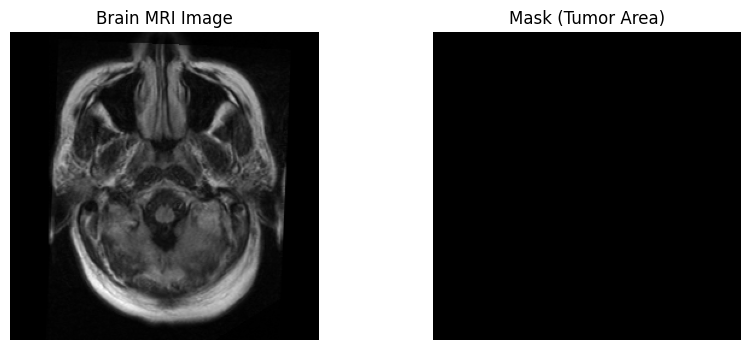

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Brain MRI Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Mask (Tumor Area)')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = 64  # smaller size for speed

def preprocess_image(path):
    img = cv2.imread(os.path.join(base_path, path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return img.flatten()

def preprocess_mask(path):
    mask = cv2.imread(os.path.join(base_path, path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = (mask > 0.5).astype(int)  # binary mask
    return mask.flatten()

# Prepare dataset (use only 100 samples for speed)
df_small = df.sample(100, random_state=42).reset_index(drop=True)

In [7]:
X = np.array([preprocess_image(p) for p in df_small['image_path']])
y = np.array([preprocess_mask(p) for p in df_small['mask_path']])

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Flatten X and y: each pixel is a sample; so reshape to (num_samples * pixels, features)
# Here feature = 1 (pixel intensity), label = 0/1 from mask

X_pixels = X.flatten().reshape(-1,1)
y_pixels = y.flatten()

In [9]:
# Split pixels into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pixels, y_pixels, test_size=0.2, random_state=42)

In [10]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [11]:
print(f"Train accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.4f}")

Train accuracy: 0.9885
Test accuracy: 0.9885


In [12]:
def predict_mask(img_path):
    img = preprocess_image(img_path)
    pred = clf.predict(img.reshape(-1,1))
    pred_img = pred.reshape(IMG_SIZE, IMG_SIZE)
    return pred_img

sample_img_path = df_small.iloc[0]['image_path']
sample_mask_path = df_small.iloc[0]['mask_path']

pred_mask = predict_mask(sample_img_path)
true_mask = preprocess_mask(sample_mask_path).reshape(IMG_SIZE, IMG_SIZE)
img = cv2.imread(os.path.join(base_path, sample_img_path), cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

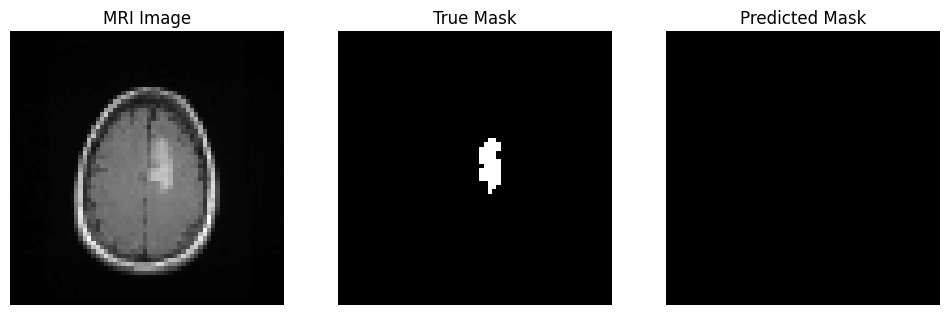

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('MRI Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('True Mask')
plt.imshow(true_mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Predicted Mask')
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.show()